### David Laziuk
### LLM Self Correction

In [1]:
# Imports:
import re
import sys
import contextlib
import pandas as pd
from typing import List
from openai import OpenAI
import matplotlib.pyplot as plt
client = OpenAI(api_key='OPENAI_API_KEY')
# Define number of trials
NUM_TRIALS = 100

#### Setup:  
PARAMETERS:  
Model: gpt-4-1106-preview  
Type: Chat  
Temperature: 1 (default)  
Maximum length: 1500 (Arbitrary, should be sufficient)  
Stop sequences: None (default) 
Top P: 1 (default) 
Frequency penalty: 0 (default) 
Presence penalty: 0 (default) 
#####  
SYSTEM:  
"You are a coding assistant. You always first break down every step of your logic in a numbered list. Each logical step should make sense independently, by defining references, and purpose of each conclusion. If there are example cases, add them to the logical breakdown. (Expanding or adding to the numbered list) Begin the code after writing flag "CODE: ", do not test examples in the code, do not write anything else after the code."
#####  
USER:  
{Task}  
"Logically Verify functionality for: "  
{Examples}  
{Constraints}  
"Build your solution on: "  
{Baseline}  
#####  
ASSISTANT:  
"Let's think step by step."

Note: This Question was selected as it is a recent "Hard" problem,  
and should not be included in this models April 2023 Context Window.  
Question 2945: Find Maximum Non-decreasing Array Length.  

# Verifying model struggles to solve problem:
### Generating initial solutions:

In [ ]:
# Defining Problem
system = """
    You are a coding assistant. \nYou always first restate the problem, by breaking down the components of the problem in a numbered list.
    \nYou then try to formulate a logical solution, you do this by breaking down the components of your solution in a new numbered list.
    \nIn the logical breakdown of the solution, you use any potential examples to prove your logic. \nEach logical step should make sense
    independently, by defining references, and purpose of each conclusion. \nAfter this, apply your logic in code.
    \nDo not write anything else after the code.\nNever test examples in the code.
    """
user = """
    You are given a 0-indexed integer array nums.\n\nYou can perform any number of operations, 
    where each operation involves selecting a subarray of the array and replacing it with the sum of its elements. 
    For example, if the given array is [1,3,5,6] and you select subarray [3,5] the array will convert to [1,8,6].
    \n\nReturn the maximum length of a non-decreasing array that can be made after applying operations.
    \n\nA subarray is a contiguous non-empty sequence of elements within an array.\n\nVerify functionality for:
    \n\nExample 1:\nInput: nums = [5,2,2]\nOutput: 1\nExplanation: This array with length 3 is not non-decreasing.
    \nWe have two ways to make the array length two.\nFirst, choosing subarray [2,2] converts the array to [5,4].
    \nSecond, choosing subarray [5,2] converts the array to [7,2].\nIn these two ways the array is not non-decreasing.
    \nAnd if we choose subarray [5,2,2] and replace it with [9] it becomes non-decreasing. \nSo the answer is 1.
    \n\nExample 2:\nInput: nums = [1,2,3,4]\nOutput: 4\nExplanation: The array is non-decreasing. So the answer is 4.
    \n\nExample 3:\nInput: nums = [4,3,2,6]\nOutput: 3\nExplanation: Replacing [3,2] with [5] converts the given array
    to [4,5,6] that is non-decreasing.\nBecause the given array is not non-decreasing, the maximum possible answer is 3.
    \n\nConstraints:\n1 <= nums.length <= 10^5\n1 <= nums[i] <= 10^5\n\nBuild your solution on:\nclass Solution:
    \n    def findMaximumLength(self, nums: List[int]) -> int:
    """
assistant= "Let's think step by step."

# Generating Initial Solutions
initial_prompt_costs=[]
initial_completion_costs=[]
for i in range(NUM_TRIALS):
    # Make the API call
    response = client.chat.completions.create(model="gpt-4-1106-preview",
      messages=[{"role": "system", "content": system},
                {"role": "user", "content": user},
                {"role": "assistant", "content": assistant}],
      temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)
    # Extract Results
    content = response.choices[0].message.content
    initial_prompt_costs.append(response.usage.prompt_tokens)
    initial_completion_costs.append(response.usage.completion_tokens)
    # Save Results to file
    content = content.replace('\\n', '\n')
    with open(f'initial/{i+1}.txt', 'w') as file:
        file.write(content)
print(f'Prompt Costs: {initial_prompt_costs}')
print(f'Completion Costs: {initial_completion_costs}')
# Save Cost Information
initial_costs = pd.DataFrame({'Prompt': initial_prompt_costs, 'Completion': initial_completion_costs})
initial_costs.to_csv('initial_costs.csv', index=False)

#### Testing Solutions:
I will now test the initial generated solutions.  
For more efficient testing, we will just run it on 3 base cases,  
If any pass, they can be manually evaluated on the full set of 553 cases.

In [2]:
# Load Initial Solutions
initial_solutions = []
# Loop through the file names
for i in range(1, NUM_TRIALS+1):
    # Construct the file name
    file_name = f"initial/{i}.txt"
    # Open the file and read its contents
    with open(file_name, 'r') as file:
        content = file.read()
        initial_solutions.append(content)

# Function to break down responses
def parse(input_string):
    try:
        # Steps Processing
        steps = input_string[:input_string.find("```")].strip() # Extract 'steps' part, everything before "```", exclusive
        steps = steps[steps.find("1."):].strip() # Remove everything before "1." in 'steps', 
        # Code Processing
        code = input_string[input_string.find("class Solution:"):].strip() # Extract 'code' part, everything after "class Solution:", inclusive
        code = code[:code.find("```")].strip() # Remove everything after "```" in 'code'
        runs = True
    except Exception as e:
        runs = False
        steps = ''
        code = ''
    return runs, steps, code

# Function to evaluate responses
def evaluate(code):
    cases = [[5, 2, 2], [1, 2, 3, 4], [4, 3, 2, 6]]
    expected_results = [1, 4, 3]
    results = {'runs': False, 'pass': False, 'Case1': False, 'Case2': False,
               'Case3': False, 'r1': None, 'r2': None, 'r3': None}
    try:
        exec(code, globals())
        solution = Solution()
        all_cases_passed = True
        for i, case in enumerate(cases):
            result = solution.findMaximumLength(case)
            results[f'r{i + 1}'] = result
            case_pass = (result == expected_results[i])
            results[f'Case{i + 1}'] = case_pass
            if not case_pass:
                all_cases_passed = False
        results['runs'] = True
        results['pass'] = all_cases_passed
    except Exception as e:
        results['runs'] = False
    return results

# Evaluating Responses
initial_results = pd.DataFrame()
num_passed = 0 
num_Perror = 0
num_Rerror = 0
# Loop through each response
for i,solution in enumerate(initial_solutions):
    runs, steps, code = parse(solution)
    # If the response parses correctly evaluate
    if runs and len(code)!=0:
        # Evaluate code with possible prints supressed
        original_print = print
        print = lambda *args, **kwargs: None
        result = evaluate(code)
        print = original_print
        # Check if the code passed all tests
        if result['pass']:
            num_passed += 1
            print(f'Solution {i+1} passed.')
        if not result['runs']:
            num_Rerror +=1
            print(f'Solution {i+1} failed to run.')
    # Else store failure
    else:
        print(f'Could not parse solution: {i+1}')
        num_Perror += 1
        result = {'runs': False, 'pass': False, 'Case1': False, 'Case2': False,
               'Case3': False, 'r1': None, 'r2': None, 'r3': None}
    initial_results = pd.concat([initial_results, pd.DataFrame([result])], ignore_index=True)
print()
print(f'{num_passed} successful out of: {len(initial_solutions)}')
print(f'{num_Perror} Samples failed to parse.')
print(f'{num_Rerror} Samples failed to run.')
initial_results.to_csv('initial_results.csv', index=False)

Could not parse solution: 7
Could not parse solution: 24
Could not parse solution: 25
Solution 30 failed to run.
Could not parse solution: 44
Could not parse solution: 54
Could not parse solution: 61
Could not parse solution: 64
Could not parse solution: 69
Could not parse solution: 75
Could not parse solution: 83
Could not parse solution: 88
Could not parse solution: 94
Could not parse solution: 97

0 successful out of: 100
13 Samples failed to parse.
1 Samples failed to run.


# Self-Correction

In [ ]:
# Correcting Logic:

# System content
system = """
    You are an expert in assessing coding logic. You will receive a problem, and then after
    \"Logical Breakdown:\", a numbered list of logic to solve this problem. For each step of logic,
    you will catch any flaws, and rewrite it to make sense. If it is perfect, rewrite it as-is.
    Never write any code.
    """
# System content for broken parsing
salvage = "Given the question, rewrite the logic to function properly."
# Redefine problem entry without "Build your solution on: ...
user = """
    You are given a 0-indexed integer array nums.\n\nYou can perform any number of operations, 
    where each operation involves selecting a subarray of the array and replacing it with the sum of its elements. 
    For example, if the given array is [1,3,5,6] and you select subarray [3,5] the array will convert to [1,8,6].
    \n\nReturn the maximum length of a non-decreasing array that can be made after applying operations.
    \n\nA subarray is a contiguous non-empty sequence of elements within an array.\n\nVerify functionality for:
    \n\nExample 1:\nInput: nums = [5,2,2]\nOutput: 1\nExplanation: This array with length 3 is not non-decreasing.
    \nWe have two ways to make the array length two.\nFirst, choosing subarray [2,2] converts the array to [5,4].
    \nSecond, choosing subarray [5,2] converts the array to [7,2].\nIn these two ways the array is not non-decreasing.
    \nAnd if we choose subarray [5,2,2] and replace it with [9] it becomes non-decreasing. \nSo the answer is 1.
    \n\nExample 2:\nInput: nums = [1,2,3,4]\nOutput: 4\nExplanation: The array is non-decreasing. So the answer is 4.
    \n\nExample 3:\nInput: nums = [4,3,2,6]\nOutput: 3\nExplanation: Replacing [3,2] with [5] converts the given array
    to [4,5,6] that is non-decreasing.\nBecause the given array is not non-decreasing, the maximum possible answer is 3.
    \n\nConstraints:\n1 <= nums.length <= 10^5\n1 <= nums[i] <= 10^5\n
    """

correction_prompt_costs=[]
correction_completion_costs=[]
for i,solution in enumerate(initial_solutions):
    # Break down response
    runs, steps, code = parse(solution)
    # If steps properly extracted do standard approach
    if runs and len(steps) !=0:
        prompt = user+f'\nLogical Breakdown:\n{steps}'
        # Get Correction
        response = client.chat.completions.create(model="gpt-4-1106-preview",
        messages=[{"role": "system", "content": system},
                  {"role": "user", "content": prompt}],
        temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)
    # If steps not exracted try to salvage
    else:
        prompt = user+f'\nAttempted logical breakdown:\n{steps}\n{code}'
        # Get Correction
        response = client.chat.completions.create(model="gpt-4-1106-preview",
        messages=[{"role": "system", "content": salvage},
                  {"role": "user", "content": prompt}],
        temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)        
    # Save Results in enviorment
    content=response.choices[0].message.content
    correction_prompt_costs.append(response.usage.prompt_tokens)
    correction_completion_costs.append(response.usage.completion_tokens)
    # Save Results to file
    content = content.replace('\\n', '\n')
    with open(f'corrections/{i+1}.txt', 'w') as file:
        file.write(content)
print(f'Prompt Costs: {correction_prompt_costs}')
print(f'Completion Costs: {correction_completion_costs}')
# Save Cost Information
correction_costs = pd.DataFrame({'Prompt': correction_prompt_costs, 'Completion': correction_completion_costs})
correction_costs.to_csv('correction_costs.csv', index=False)

### Apply Corrections

In [ ]:
# Load Corrections
corrected_logic = []
for i in range(1, NUM_TRIALS+1):
    file_name = f"corrections/{i}.txt"
    with open(file_name, 'r') as file:
        content = file.read()
        corrected_logic.append(content)

# Define Content
system = """You are an expert in python. When receiving a problem, you'll logically break down the solution step
    by step, and verify it's correct.  Then, you will apply this logic to write code to solve the problem.
    Never test examples in your code."""
user = """Task:\nYou are given a 0-indexed integer array nums.\nYou can perform any number of operations,
    where each operation involves selecting a subarray of the array and replacing it with the sum of its elements.
    For example, if the given array is [1,3,5,6] and you select subarray [3,5] the array will convert to [1,8,6].
    \nReturn the maximum length of a non-decreasing array that can be made after applying operations.\nA subarray
    is a contiguous non-empty sequence of elements within an array.\nLogically Verify functionality for:
    \nExamples:\nExample 1:\nInput: nums = [5,2,2]\nOutput: 1\nExplanation: This array with length 3 is not
    non-decreasing.\nWe have two ways to make the array length two.\nFirst, choosing subarray [2,2] converts the
    array to [5,4].\nSecond, choosing subarray [5,2] converts the array to [7,2].\nIn these two ways the array is
    not non-decreasing.\nAnd if we choose subarray [5,2,2] and replace it with [9] it becomes non-decreasing. So
    the answer is 1.\nExample 2:\nInput: nums = [1,2,3,4]\nOutput: 4\nExplanation: The array is non-decreasing.
    So the answer is 4.\nExample 3:\nInput: nums = [4,3,2,6]\nOutput: 3\nExplanation: Replacing [3,2] with [5]
    converts the given array to [4,5,6] that is non-decreasing. Because the given array is not non-decreasing,
    the maximum possible answer is 3.\nConstraints:\n1 <= nums.length <= 10^5\n1 <= nums[i] <= 10^5\n\nBuild
    your solution on:\n\nclass Solution: \n    def findMaximumLength(self, nums: List[int]) -> int:"""
assistant = "Lets think step by step.\n\n"

# Generate code
final_prompt_costs=[]
final_completion_costs=[]
# Rate limited, modifiying loop from: for i,logic in enumerate(corrected_logic):
for i in range(44, 100):
    logic = corrected_logic[i]
    main = assistant + logic + "\nLets write code to apply this logic:"
    response = client.chat.completions.create(model="gpt-4-1106-preview",
      messages=[{"role": "system","content": system},
                {"role": "user","content": user},
                {"role": "assistant","content": main}],
      temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)
    # Save Results in enviorment
    content=response.choices[0].message.content
    final_prompt_costs.append(response.usage.prompt_tokens)
    final_completion_costs.append(response.usage.completion_tokens)
    # Save Results to file
    content = content.replace('\\n', '\n')
    with open(f'final/{i+1}.txt', 'w') as file:
        file.write(content)
print(f'Final Prompt Costs: {final_prompt_costs}')
print(f'Final Completion Costs: {final_completion_costs}')
# Save Cost Information
final_costs = pd.DataFrame({'Prompt': final_prompt_costs, 'Completion': final_completion_costs})
final_costs.to_csv('final_costs.csv', index=False)

### Evaluating new solutions

In [3]:
# Load Solutions
final_solutions = []
for i in range(1, NUM_TRIALS+1):
    file_name = f"final/{i}.txt"
    with open(file_name, 'r') as file:
        content = file.read()
        final_solutions.append(content)

# Evaluating Responses
final_results = pd.DataFrame()
num_passed = 0 
num_Perror = 0
num_Rerror = 0
# Loop through each response
for i,solution in enumerate(final_solutions):
    runs, steps, code = parse(solution)
    # If the response parses correctly evaluate
    if runs and len(code)!=0:
        # Evaluate code with possible prints supressed
        original_print = print
        print = lambda *args, **kwargs: None
        result = evaluate(code)
        print = original_print
        # Check if the code passed all tests
        if result['pass']:
            num_passed += 1
            print(f'Solution {i+1} passed.')
        if not result['runs']:
            num_Rerror +=1
            print(f'Solution {i+1} failed to run.')
    # Else store failure
    else:
        print(f'Could not parse solution: {i+1}')
        num_Perror += 1
        result = {'runs': False, 'pass': False, 'Case1': False, 'Case2': False,
               'Case3': False, 'r1': None, 'r2': None, 'r3': None}
    final_results = pd.concat([final_results, pd.DataFrame([result])], ignore_index=True)
print()
print(f'{num_passed} successful out of: {len(final_solutions)}')
print(f'{num_Perror} Samples failed to parse.')
print(f'{num_Rerror} Samples failed to run.')
final_results.to_csv('final_results.csv', index=False)

Solution 44 passed.

1 successful out of: 100
0 Samples failed to parse.
0 Samples failed to run.


### EDA

Initial Runs had 14 trials failed to run
Final Runs had 0 trials failed to run


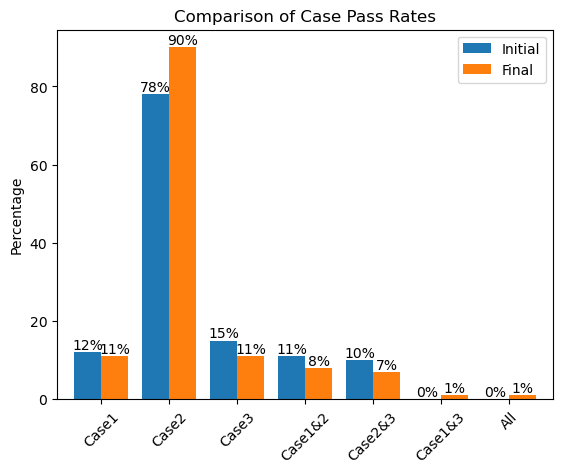

COSTS             | Avg T  | Tot T  | Avg $  | Tot $ |
-----------------------------------------------------
Initial Prompt:   | 567.0  | 56700  | 0.0057 |  0.57 |
Initial Response: | 549.6  | 54961  | 0.0165 |  1.6  |
Initial Total:    | 1116.6 | 111661 | 0.0222 |  2.2  |
-----------------------------------------------------
Correct Prompt:   | 834.8  | 83480  | 0.0083 |  0.83 |
Correct Response: | 625.9  | 62589  | 0.0188 |  1.9  |
Correct Total:    | 1460.7 | 146069 | 0.0271 |  2.7  |
-----------------------------------------------------
Final Prompt:     | 1114.8 | 71346  | 0.0111 |  0.71 |
Final Response:   | 396.9  | 25402  | 0.0119 |  0.76 |
Final Total:      | 1511.7 | 96748  | 0.0231 |  1.5  |
-----------------------------------------------------
Average Cost of regular solution:   $0.0222
Average Cost of corrected solution: $0.0724
3.3x more expensive


In [4]:
# Loading Stats:
initial_costs = pd.read_csv('initial_costs.csv')
initial_results = pd.read_csv('initial_results.csv')
correction_costs = pd.read_csv('correction_costs.csv')
final_costs = pd.read_csv('final_costs.csv')
final_results = pd.read_csv('final_results.csv')

# Performance Breakdown:
missing_initial = initial_results.isnull().any(axis=1).sum()
missing_final = final_results.isnull().any(axis=1).sum()
print(f"Initial Runs had {missing_initial} trials failed to run")
print(f"Final Runs had {missing_final} trials failed to run")
initial_results[['Case1', 'Case2', 'Case3']] = initial_results[['Case1', 'Case2', 'Case3']].fillna(False)
final_results[['Case1', 'Case2', 'Case3']] = final_results[['Case1', 'Case2', 'Case3']].fillna(False)

# Calculate percentages of cases passed
def calculate_percentages(df):
    percentages = {
        'Case1': df['Case1'].mean(),
        'Case2': df['Case2'].mean(),
        'Case3': df['Case3'].mean(),
        'Case1&2': df[['Case1', 'Case2']].all(axis=1).mean(),
        'Case2&3': df[['Case2', 'Case3']].all(axis=1).mean(),
        'Case1&3': df[['Case1', 'Case3']].all(axis=1).mean(),
        'All': df[['Case1', 'Case2', 'Case3']].all(axis=1).mean()}
    return pd.Series(percentages) * 100
percent_initial = calculate_percentages(initial_results)
percent_final = calculate_percentages(final_results)
plot_data = pd.DataFrame({'Initial': percent_initial, 'Final': percent_final})
ax = plot_data.plot(kind='bar', width=0.8)
plt.title('Comparison of Case Pass Rates')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

# Cost EDA
def cost(df, name):
    avgP = df['Prompt'].mean()
    avgC = df['Completion'].mean()
    totP = df['Prompt'].sum()
    totC = df['Completion'].sum()
    avgPD = (avgP/1000)*.01
    avgCD = (avgC/1000)*.03
    totPD = (totP/1000)*.01
    totCD = (totC/1000)*.03
    print('-----------------------------------------------------')
    print(f"{name + ' Prompt:':<18}| {avgP:<7.1f}| {totP:<6} | {round(avgPD,4):<6} |  {round(totPD,2):<4.2} |")
    print(f"{name + ' Response:':<18}| {avgC:<7.1f}| {totC:<6} | {round(avgCD,4):<6} |  {round(totCD,2):<4.2} |")
    print(f"{name + ' Total:':<18}| {avgC + avgP:<7.1f}| {totP + totC:<6} | {round(avgPD + avgCD,4):<6} |  {round(totPD + totCD,2):<4.2} |")
print('COSTS             | Avg T  | Tot T  | Avg $  | Tot $ |')
cost(initial_costs, 'Initial')
cost(correction_costs, 'Correct')
cost(final_costs, 'Final')
print('-----------------------------------------------------')
print('Average Cost of regular solution:   $0.0222')
print(f'Average Cost of corrected solution: ${round(0.0222+0.0271+0.0231,4)}')
print(f'{round((.0724/.0222),1)}x more expensive')

# Slightly Easier Problem:

In [5]:
NUM_TRIALS = 10

In [ ]:
# Defining Problem
system = """
    You are a coding assistant. You always first restate the problem, by breaking down the components of the problem in a numbered list.
    \nYou then try to formulate a logical solution, you do this by breaking down the components of your solution in a new numbered list.
    \nIn the logical breakdown of the solution, you use any potential examples to prove your logic. Each logical step should make sense
    independently, by defining references, and purpose of each conclusion. \nAfter this, apply your logic in code.\n
    Do not write anything else after the code.\nNever test examples in the code.
    """
user = """
    Given a string s and an integer k, partition s into k substrings such that the sum of the number of letter changes required to turn
    each substring into a semi-palindrome is minimized.\n\nReturn an integer denoting the minimum number of letter changes required.\n\n
    Notes\n\nA string is a palindrome if it can be read the same way from left to right and right to left.\nA string with a length of
    len is considered a semi-palindrome if there exists a positive integer d such that 1 <= d < len and len % d == 0, and if we take
    indices that have the same modulo by d, they form a palindrome. For example, \"aa\", \"aba\", \"adbgad\", and, \"abab\" are
    semi-palindrome and \"a\", \"ab\", and, \"abca\" are not.\nA substring is a contiguous sequence of characters within a string.
    \n\nBuild solution on:\nclass Solution:\n    def minimumChanges(self, s: str, k: int) -> int:
    """
assistant= "Let's think step by step."

# Generating Initial Solutions
initial_prompt_costs=[]
initial_completion_costs=[]
for i in range(NUM_TRIALS):
    # Make the API call
    response = client.chat.completions.create(model="gpt-4-1106-preview",
      messages=[{"role": "system", "content": system},
                {"role": "user", "content": user},
                {"role": "assistant", "content": assistant}],
      temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)
    # Extract Results
    content = response.choices[0].message.content
    initial_prompt_costs.append(response.usage.prompt_tokens)
    initial_completion_costs.append(response.usage.completion_tokens)
    # Save Results to file
    content = content.replace('\\n', '\n')
    with open(f'initialEZ/{i+1}.txt', 'w') as file:
        file.write(content)
print(f'Prompt Costs: {initial_prompt_costs}')
print(f'Completion Costs: {initial_completion_costs}')
# Save Cost Information
initial_costs = pd.DataFrame({'Prompt': initial_prompt_costs, 'Completion': initial_completion_costs})
initial_costs.to_csv('initial_costsEZ.csv', index=False)

In [6]:
# Testing Solutions
# Load Initial Solutions
initial_solutions = []
# Loop through the file names
for i in range(1, NUM_TRIALS+1):
    # Construct the file name
    file_name = f"initialEZ/{i}.txt"
    # Open the file and read its contents
    with open(file_name, 'r') as file:
        content = file.read()
        initial_solutions.append(content)

# Function to break down responses
def parse(input_string):
    try:
        # Steps Processing
        steps = input_string[:input_string.find("```")].strip() # Extract 'steps' part, everything before "```", exclusive
        steps = steps[steps.find("1."):].strip() # Remove everything before "1." in 'steps', 
        # Code Processing
        code = input_string[input_string.find("class Solution:"):].strip() # Extract 'code' part, everything after "class Solution:", inclusive
        code = code[:code.find("```")].strip() # Remove everything after "```" in 'code'
        runs = True
    except Exception as e:
        runs = False
        steps = ''
        code = ''
    return runs, steps, code

# Function to evaluate responses
def evaluate(code):
    cases = ['abcac', 'abcdef', 'aabbaa']
    ks = [2, 2, 3]
    expected_results = [1, 2, 0]
    results = {'runs': False, 'pass': False, 'Case1': False, 'Case2': False,
               'Case3': False, 'r1': None, 'r2': None, 'r3': None}
    try:
        exec(code, globals())
        solution = Solution()
        all_cases_passed = True
        for i, case in enumerate(cases):
            k = ks[i]
            result = solution.minimumChanges(case,k)
            results[f'r{i + 1}'] = result
            case_pass = (result == expected_results[i])
            results[f'Case{i + 1}'] = case_pass
            if not case_pass:
                all_cases_passed = False
        results['runs'] = True
        results['pass'] = all_cases_passed
    except Exception as e:
        results['runs'] = False
        print(e)
    return results

# Evaluating Responses
initial_results = pd.DataFrame()
num_passed = 0 
num_Perror = 0
num_Rerror = 0
# Loop through each response
for i,solution in enumerate(initial_solutions):
    runs, steps, code = parse(solution)
    # If the response parses correctly evaluate
    if runs and len(code)!=0:
        # Evaluate code with possible prints supressed
        original_print = print
        print = lambda *args, **kwargs: None
        result = evaluate(code)
        print = original_print
        # Check if the code passed all tests
        if result['pass']:
            num_passed += 1
            print(f'Solution {i+1} passed.')
        if not result['runs']:
            num_Rerror +=1
            print(f'Solution {i+1} failed to run.')
    # Else store failure
    else:
        print(f'Could not parse solution: {i+1}')
        num_Perror += 1
        result = {'runs': False, 'pass': False, 'Case1': False, 'Case2': False,
               'Case3': False, 'r1': None, 'r2': None, 'r3': None}
    initial_results = pd.concat([initial_results, pd.DataFrame([result])], ignore_index=True)
print()
print(f'{num_passed} successful out of: {len(initial_solutions)}')
print(f'{num_Perror} Samples failed to parse.')
print(f'{num_Rerror} Samples failed to run.')
initial_results.to_csv('initial_resultsEZ.csv', index=False)

Solution 4 failed to run.
Solution 7 failed to run.

0 successful out of: 10
0 Samples failed to parse.
2 Samples failed to run.


In [ ]:
# Correcting Logic:

# System content
system = """
    You are an expert in assessing coding logic. You will receive a problem, and then after
    \"Logical Breakdown:\", a numbered list of logic to solve this problem. For each step of logic,
    you will catch any flaws, and rewrite it to make sense given the problem. If it is perfect, rewrite it as-is.
    Never write any code.
    """
# System content for broken parsing
salvage = "Given the question, rewrite the logic to function properly."
# Redefine problem entry without "Build your solution on: ...
user = """
    Given a string s and an integer k, partition s into k substrings such that the sum of the number of letter changes required to turn
    each substring into a semi-palindrome is minimized.\n\nReturn an integer denoting the minimum number of letter changes required.\n\n
    Notes\n\nA string is a palindrome if it can be read the same way from left to right and right to left.\nA string with a length of
    len is considered a semi-palindrome if there exists a positive integer d such that 1 <= d < len and len % d == 0, and if we take
    indices that have the same modulo by d, they form a palindrome. For example, \"aa\", \"aba\", \"adbgad\", and, \"abab\" are
    semi-palindrome and \"a\", \"ab\", and, \"abca\" are not.\nA substring is a contiguous sequence of characters within a string.
    """

correction_prompt_costs=[]
correction_completion_costs=[]
for i,solution in enumerate(initial_solutions):
    # Break down response
    runs, steps, code = parse(solution)
    # If steps properly extracted do standard approach
    if runs and len(steps) !=0:
        prompt = user+f'\nLogical Breakdown:\n{steps}'
        # Get Correction
        response = client.chat.completions.create(model="gpt-4-1106-preview",
        messages=[{"role": "system", "content": system},
                  {"role": "user", "content": prompt}],
        temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)
    # If steps not exracted try to salvage
    else:
        prompt = user+f'\nAttempted logical breakdown:\n{steps}\n{code}'
        # Get Correction
        response = client.chat.completions.create(model="gpt-4-1106-preview",
        messages=[{"role": "system", "content": salvage},
                  {"role": "user", "content": prompt}],
        temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)        
    # Save Results in enviorment
    content=response.choices[0].message.content
    correction_prompt_costs.append(response.usage.prompt_tokens)
    correction_completion_costs.append(response.usage.completion_tokens)
    # Save Results to file
    content = content.replace('\\n', '\n')
    with open(f'correctionsEZ/{i+1}.txt', 'w') as file:
        file.write(content)
print(f'Prompt Costs: {correction_prompt_costs}')
print(f'Completion Costs: {correction_completion_costs}')
# Save Cost Information
correction_costs = pd.DataFrame({'Prompt': correction_prompt_costs, 'Completion': correction_completion_costs})
correction_costs.to_csv('correction_costsEZ.csv', index=False)

In [ ]:
# Load Corrections
corrected_logic = []
for i in range(1, NUM_TRIALS+1):
    file_name = f"correctionsEZ/{i}.txt"
    with open(file_name, 'r') as file:
        content = file.read()
        corrected_logic.append(content)

# Define Content
system = """You are an expert in python. \nYou will receive a problem, faulty code, and
logic that attempts to correct this code.\nApply this logic to fix this code for the problem."""

user = """Given a string s and an integer k, partition s into k substrings such that the sum of the number of letter changes required to turn
    each substring into a semi-palindrome is minimized.\n\nReturn an integer denoting the minimum number of letter changes required.\n\n
    Notes\n\nA string is a palindrome if it can be read the same way from left to right and right to left.\nA string with a length of
    len is considered a semi-palindrome if there exists a positive integer d such that 1 <= d < len and len % d == 0, and if we take
    indices that have the same modulo by d, they form a palindrome. For example, \"aa\", \"aba\", \"adbgad\", and, \"abab\" are
    semi-palindrome and \"a\", \"ab\", and, \"abca\" are not.\nA substring is a contiguous sequence of characters within a string.
    \n\nBuild solution on:\nclass Solution:\n    def minimumChanges(self, s: str, k: int) -> int:"""

# Generate code
final_prompt_costs=[]
final_completion_costs=[]
for i,logic in enumerate(corrected_logic):
    _, _, old_code = parse(initial_solutions[i])
    main = user + '\nFaulty Code:\n' + old_code +'\nCorrected Logic\n'+ logic
    response = client.chat.completions.create(model="gpt-4-1106-preview",
      messages=[{"role": "system","content": system},
                {"role": "user","content": main}],
      temperature=1, max_tokens=1500, top_p=1, frequency_penalty=0, presence_penalty=0)
    # Save Results in enviorment
    content=response.choices[0].message.content
    final_prompt_costs.append(response.usage.prompt_tokens)
    final_completion_costs.append(response.usage.completion_tokens)
    # Save Results to file
    content = content.replace('\\n', '\n')
    with open(f'finalEZ/{i+1}.txt', 'w') as file:
        file.write(content)
print(f'Final Prompt Costs: {final_prompt_costs}')
print(f'Final Completion Costs: {final_completion_costs}')
# Save Cost Information
final_costs = pd.DataFrame({'Prompt': final_prompt_costs, 'Completion': final_completion_costs})
final_costs.to_csv('final_costsEZ.csv', index=False)

In [7]:
# Load Solutions
final_solutions = []
for i in range(1, NUM_TRIALS+1):
    file_name = f"finalEZ/{i}.txt"
    with open(file_name, 'r') as file:
        content = file.read()
        final_solutions.append(content)

# Evaluating Responses
final_results = pd.DataFrame()
num_passed = 0 
num_Perror = 0
num_Rerror = 0
# Loop through each response
for i,solution in enumerate(final_solutions):
    runs, steps, code = parse(solution)
    # If the response parses correctly evaluate
    if runs and len(code)!=0:
        # Evaluate code with possible prints supressed
        original_print = print
        print = lambda *args, **kwargs: None
        result = evaluate(code)
        print = original_print
        # Check if the code passed all tests
        if result['pass']:
            num_passed += 1
            print(f'Solution {i+1} passed.')
        if not result['runs']:
            num_Rerror +=1
            print(f'Solution {i+1} failed to run.')
    # Else store failure
    else:
        print(f'Could not parse solution: {i+1}')
        num_Perror += 1
        result = {'runs': False, 'pass': False, 'Case1': False, 'Case2': False,
               'Case3': False, 'r1': None, 'r2': None, 'r3': None}
    final_results = pd.concat([final_results, pd.DataFrame([result])], ignore_index=True)
print()
print(f'{num_passed} successful out of: {len(final_solutions)}')
print(f'{num_Perror} Samples failed to parse.')
print(f'{num_Rerror} Samples failed to run.')
final_results.to_csv('final_resultsEZ.csv', index=False)

Solution 2 passed.
Solution 4 failed to run.
Solution 5 passed.
Solution 7 failed to run.

2 successful out of: 10
0 Samples failed to parse.
2 Samples failed to run.


Initial Runs had 3 trials failed to run
Final Runs had 2 trials failed to run


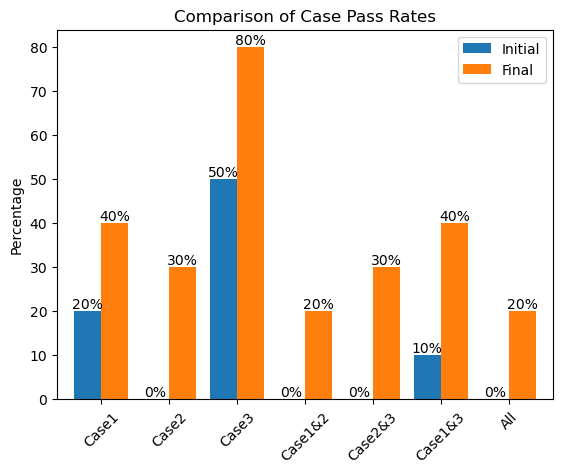

COSTS             | Avg T  | Tot T  | Avg $  | Tot $ |
-----------------------------------------------------
Initial Prompt:   | 366.0  | 3660   | 0.0037 |  0.04 |
Initial Response: | 840.1  | 8401   | 0.0252 |  0.25 |
Initial Total:    | 1206.1 | 12061  | 0.0289 |  0.29 |
-----------------------------------------------------
Correct Prompt:   | 747.7  | 7477   | 0.0075 |  0.07 |
Correct Response: | 617.2  | 6172   | 0.0185 |  0.19 |
Correct Total:    | 1364.9 | 13649  | 0.026  |  0.26 |
-----------------------------------------------------
Final Prompt:     | 1230.8 | 12308  | 0.0123 |  0.12 |
Final Response:   | 636.0  | 6360   | 0.0191 |  0.19 |
Final Total:      | 1866.8 | 18668  | 0.0314 |  0.31 |
-----------------------------------------------------
Average Cost of regular solution:   $0.0289
Average Cost of corrected solution: $0.0863
3.0x more expensive


In [8]:
# Loading Stats:
initial_costs = pd.read_csv('initial_costsEZ.csv')
initial_results = pd.read_csv('initial_resultsEZ.csv')
correction_costs = pd.read_csv('correction_costsEZ.csv')
final_costs = pd.read_csv('final_costsEZ.csv')
final_results = pd.read_csv('final_resultsEZ.csv')

# Performance Breakdown:
missing_initial = initial_results.isnull().any(axis=1).sum()
missing_final = final_results.isnull().any(axis=1).sum()
print(f"Initial Runs had {missing_initial} trials failed to run")
print(f"Final Runs had {missing_final} trials failed to run")
initial_results[['Case1', 'Case2', 'Case3']] = initial_results[['Case1', 'Case2', 'Case3']].fillna(False)
final_results[['Case1', 'Case2', 'Case3']] = final_results[['Case1', 'Case2', 'Case3']].fillna(False)

# Calculate percentages of cases passed
def calculate_percentages(df):
    percentages = {
        'Case1': df['Case1'].mean(),
        'Case2': df['Case2'].mean(),
        'Case3': df['Case3'].mean(),
        'Case1&2': df[['Case1', 'Case2']].all(axis=1).mean(),
        'Case2&3': df[['Case2', 'Case3']].all(axis=1).mean(),
        'Case1&3': df[['Case1', 'Case3']].all(axis=1).mean(),
        'All': df[['Case1', 'Case2', 'Case3']].all(axis=1).mean()}
    return pd.Series(percentages) * 100
percent_initial = calculate_percentages(initial_results)
percent_final = calculate_percentages(final_results)
plot_data = pd.DataFrame({'Initial': percent_initial, 'Final': percent_final})
ax = plot_data.plot(kind='bar', width=0.8)
plt.title('Comparison of Case Pass Rates')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}%", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

# Cost EDA
def cost(df, name):
    avgP = df['Prompt'].mean()
    avgC = df['Completion'].mean()
    totP = df['Prompt'].sum()
    totC = df['Completion'].sum()
    avgPD = (avgP/1000)*.01
    avgCD = (avgC/1000)*.03
    totPD = (totP/1000)*.01
    totCD = (totC/1000)*.03
    print('-----------------------------------------------------')
    print(f"{name + ' Prompt:':<18}| {avgP:<7.1f}| {totP:<6} | {round(avgPD,4):<6} |  {round(totPD,2):<4.2} |")
    print(f"{name + ' Response:':<18}| {avgC:<7.1f}| {totC:<6} | {round(avgCD,4):<6} |  {round(totCD,2):<4.2} |")
    print(f"{name + ' Total:':<18}| {avgC + avgP:<7.1f}| {totP + totC:<6} | {round(avgPD + avgCD,4):<6} |  {round(totPD + totCD,2):<4.2} |")
print('COSTS             | Avg T  | Tot T  | Avg $  | Tot $ |')
cost(initial_costs, 'Initial')
cost(correction_costs, 'Correct')
cost(final_costs, 'Final')
print('-----------------------------------------------------')
print('Average Cost of regular solution:   $0.0289')
print(f'Average Cost of corrected solution: ${round(0.0289+0.026+0.0314,4)}')
print(f'{round((.0863/.0289),1)}x more expensive')